In [1]:
%matplotlib inline
import matplotlib.ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoLocator
#plt.style.use('seaborn')
plt.style.use('seaborn-white')
import numpy as np
from scipy import special as sp
import itertools
import pandas as pd
import os

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/_0notebooks')

In [3]:
pwd

'/content/drive/MyDrive/Colab Notebooks/_0notebooks'

In [4]:
def gain_Reader(theta=0,phi=0):
  """
  'theta' es la elevación (rad)
  'phi' es el azimuth (rad)
  """
  theta = np.pi/2 - theta
  return 3.136*(np.tan(theta)*np.sin(np.pi/2*np.cos(theta))*np.cos(np.pi/2*np.sin(theta)*np.sin(phi)) )**2
  #return 3.136*(np.tan(alpha)*np.sin(np.pi/2*np.cos(alpha))*np.cos(np.pi/2*np.sin(alpha)*np.sin(phi)) )**2

In [5]:
def gain_Tag(theta=0, phi=0):
  """
  'theta' es la elevación (rad)
  'phi' es el azimuth. Tiene forma de toroide y no influye  (rad)
  """
  epsilon = 1E-32 # añado un epsilon para evitar las singularidades 
  # en pi/2 y 3pi/2
  if theta == 0:
    theta = theta + epsilon
  return 1.641*(np.cos(np.pi/2*np.cos(theta))/np.sin(theta))**2

In [6]:
def ricianrnd (s=np.sqrt(3), sgm=1/np.sqrt(2), dim=1):
    x = sgm*np.random.normal(0,1, dim) + s
    y = sgm*np.random.normal(0,1, dim)
    return np.sqrt(x**2 + y**2)

In [7]:
def Q_fun(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [8]:
def CA(r,lam):
    """
    CA es el coeficiente de atenuación a distancia 'r'
    y wavelength 'lam'
    """
    return ((4*np.pi*r/lam)**2)

In [9]:
def Powers(d_1=1, d_2=1, phi_1=0, theta_1=0, phi_2=0, theta_2=0):
  """
  'd_1' distancia entre antena TX y tag
  'd_2' distancia entre antena tag y RX
  'theta' es la elevación (rad)
  'phi' es el azimuth. Tiene forma de toroide y no influye  (rad)
  Devuelve (dBm) la (Pw_Tx x G_Tx) en el transmisor, la Pw_up, Pw_back,
  y, devuelve si se activa el tag (active) y si se lee el tag (inventoried)
  """
  pwup_thres = -19 # (dBm) power up threshold del tag
  reader_sens = -80 # (dBm)
  B = 2e5 #(Hz), bandwidth
  freq = 865.7 # (MHz) 
  lmb = 300/freq 
  PwTx = 0.35 # (W) pot TX
  GR = gain_Reader(theta_1, phi_1)
  GT = gain_Tag(theta_2, phi_2)
  #print(GR)
  #print(GT)
  ERP = 10*np.log10( 1000*(PwTx * GR) ) # dBm
  tau = 1 # Power transmiss coeficient
  oogp = 1.2 # on object gain penalty, =1.2 para cardboard, 1-> no penalty
  rcn_tx = ricianrnd()[0]
  #Pw_up_lin = (PwTx*GR*GT*tau) / (oogp) /CA(d_1,lmb) * rcn_tx
  F = 7
  #SHADOWING
  sigma = 1. # es lineal para dB hacer log
  N_1 = np.random.normal(0,sigma)#,D.shape)
  rnd = 10**(-N_1/10)
#
  Pw_up_lin = (PwTx*GR*GT*tau) / (oogp) /CA(d_1,lmb)/F 
  Pw_up = 10*np.log10( 1000*(Pw_up_lin) )
  #print(Pw_up)
  #print('2')
  if (Pw_up >= pwup_thres):
    # el tag se activa
    active_tag = True
    M = 0.25 # coeficiente de modulación
    rcn_rx = ricianrnd()[0]
    #Pw_back_lin = (PwTx*(GR*GT)**2)*M/(oogp**2)*(1/CA(d_1,lmb))*(1/CA(d_2,lmb)) *rcn_tx*rcn_rx
    F = 11
    Pw_back_lin = (PwTx*(GR*GT)**2)*M/(oogp**2)*(1/CA(d_1,lmb))*(1/CA(d_2,lmb))/F 
    Pw_back = 10*np.log10( 1000*(Pw_back_lin) )
    BLF = 320e3 #  40kHz # Tabla 6.9 pg32 Standar (backscatter-link frequency)
    SNR_linear = (Pw_back_lin / BLF / 8.177584027e-16)
    m = 8 
    BER = 2*Q_fun (np.sqrt(m*SNR_linear)) * (1 - Q_fun (np.sqrt(m*SNR_linear)) ) 
    p_error =  1 - ( 1 - BER)**96 # PC+EPC+CRC16= 16+16*4+16 (Annex K standard)
    aleatorio = np.random.random(1)[0]
    # print(BER,p_error,aleatorio)
    if (p_error <= aleatorio) and (Pw_back >= reader_sens):
      # el tag SI se lee
      inventoried = True
      phase = (-2*np.pi*(d_1 + d_2)/lmb) % (2*np.pi) # <--- PHASE
    else:
      # el tag NO se lee
      inventoried = False
      phase = float('nan')

  else:
    # el tag no se activa
    active_tag = False
    inventoried = False
    phase = float('nan')
    Pw_back_lin = 8.177584027e-16 # Thermal noise kTW
    Pw_back = 10*np.log10( 1000*(Pw_back_lin) ) # (= -120.87 dBm)
  # return ((active_tag), (inventoried), ERP, Pw_up, Pw_back)
  #return ( inventoried, phase, np.rad2deg(phase) )
  return ( phase )

In [10]:
def psi(t, f, psi_0):
  t = t%(1/f)
  calculapsi = lambda t: -np.pi/2 +2*psi_0 +(np.pi-2*psi_0)*2*f*t if t<1/(2*f) else (np.pi-2*psi_0)/(-1/(2*f))*t +(3*np.pi/2-2*psi_0)
  return np.array([calculapsi(tvalue) for tvalue in t])

In [11]:
def fasesim(tsim:10, f:0.25, d0:1):
   """
   'tsim' tiempo de sim
   'f' freq de oscilación. Defecto 1 osc. por cada 4 s (.25Hz)
   'd0' distancia inicial tag-reader
   """
   inc = 1/35
   psi_0 = np.arctan(0.27/np.pi/0.22)
   #print((np.pi-2*psi_0)/9)
   ta = np.arange(0, tsim + inc, inc)
   #print(ta)
   #f = 1/4 # Hz o menos
   umbral = np.pi/2-2*psi_0
   psi_t = psi(ta,f,psi_0)
   #print(psi_t)
   #max(psi_t), min(psi_t)
   l = 0.22 #m
   h = 0.27/np.pi #m
   #d0 = 10 #m
   r = np.sqrt(l**2 +h**2)
   d_t = np.sqrt((l-r*np.cos(psi_t))**2 + (d0+h-r*np.sin(psi_t))**2)
   theta_1 = np.arctan( (l-r*np.cos(psi_t))/(d0+h-r*np.sin(psi_t)) )
   theta_2= np.pi/2 - theta_1 - psi_t + psi_0
   #col_names = ['read?', 'phs_rad','phs_deg' ]
   # Creo un pandas dataset con cols los puntos de muestra:
   col_names = [str(ta) for ta in ta]
   df = pd.DataFrame(columns = col_names)
   
   elevation1 = theta_1
   elevation2 = np.pi/2-theta_2
   azimuth1 = 0
   azimuth2 = 0
   N = 1
   p_all = np.array([])
   for i in range(ta.shape[0]):
     #print(d_t[i])
     p = Powers(d_t[i], d_t[i], azimuth1, elevation1[i], azimuth2 , elevation2[i])
     p_all = np.append(p_all, p)
   
   return (ta, p_all, psi_t, d_t)

#for _ in itertools.repeat(None, N): 
 # p = Powers(d_t, d_t, elevation1, azimuth1, elevation2, azimuth2)
  #p = np.asarray(p)
  #print(p) #, print(p_all.shape)
  # el reshape no haría falta, sólo un elemento en 'p'
  #df = df.append(pd.DataFrame(p.reshape(1,-1), columns=list(df)), ignore_index=True)

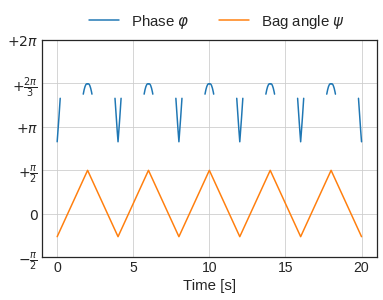

In [12]:
d0 = 4
tsim = 20
f_osc = 1/4 # 1 osc por cada 4s
elt,elph,elpsi,dist = fasesim(tsim, f_osc, d0)
fig = plt.figure()#(figsize=(8,5))
ax  = fig.add_subplot(111)
#https://stackoverflow.com/questions/43741928/matplotlib-raw-latex-epsilon-only-yields-varepsilon
ax.plot(elt,elph, label='Phase $φ$' , labelsize=15) # OJO ese sym es \varphi
ax.plot(elt,elpsi, label='Bag angle $\psi$')
unit = 0.5

y_tick = np.arange(-0.5, 2+unit, unit)
y_label = [r"$-\frac{\pi}{2}$", r"$0$", r"$+\frac{\pi}{2}$", r"$+\pi$",  r"$+\frac{2\pi}{3}$",   r"$+2\pi$"]
ax.set_yticks(y_tick*np.pi)
ax.set_yticklabels(y_label, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.xlabel('Time [s]', fontsize=15)
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot-in-matplotlib
plt.legend(bbox_to_anchor=(0.1,0.98,1,0.2), loc="lower left", ncol=2, fontsize=13)
plt.grid()
#y_tick = np.arange(-0.5, 2+unit, unit)  
#y_label1 = [r"$" + format(r, ".2g")+ r"\pi$" for r in y_tick]
#ax = ax.twinx()
#ax.set_yticks(y_tick*np.pi)
#ax.set_yticklabels(y_label1, fontsize=10)
#
#plt.savefig('fase'+ str(d0)+'m'+'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


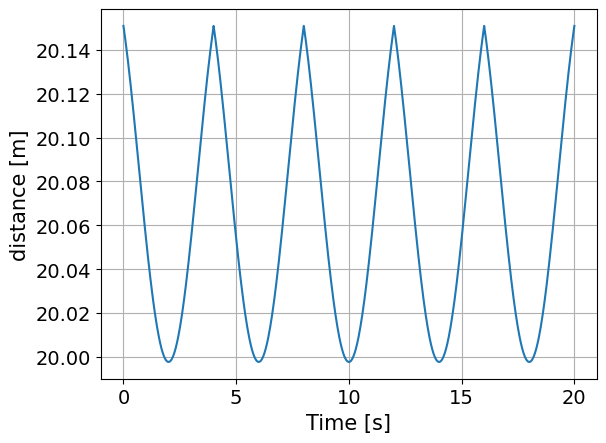

In [ ]:
d0 = 10
tsim = 20
f_osc = 1/4 # 1 osc por cada 4s
elt,elph,elpsi,dist = fasesim(tsim, f_osc, d0)

mpl.rcParams.update(mpl.rcParamsDefault)
fig = plt.figure()#(figsize=(8,5))
ax  = fig.add_subplot(111)
ax.plot(elt,dist)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('distance [m]', fontsize=15)
plt.grid()
plt.show()